# Mohamed-Idriss Naour
# Walid Bahad


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Chargement du dataset

In [3]:
#  À MODIFIER avec le chemin de votre dataset
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Deep Learning CNN DIABETIC/DATASETDIABETIC"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Séparation validation / test à partir du split validation
val_test_batches = tf.data.experimental.cardinality(val_test_ds).numpy()
val_batches = val_test_batches // 2

val_ds  = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes :", class_names)
print("Nombre de classes :", num_classes)

# Optimisation du pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Found 1986 files belonging to 5 classes.
Using 1589 files for training.
Found 1986 files belonging to 5 classes.
Using 397 files for validation.
Classes : ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']
Nombre de classes : 5


## 2. Visualisation de quelques images

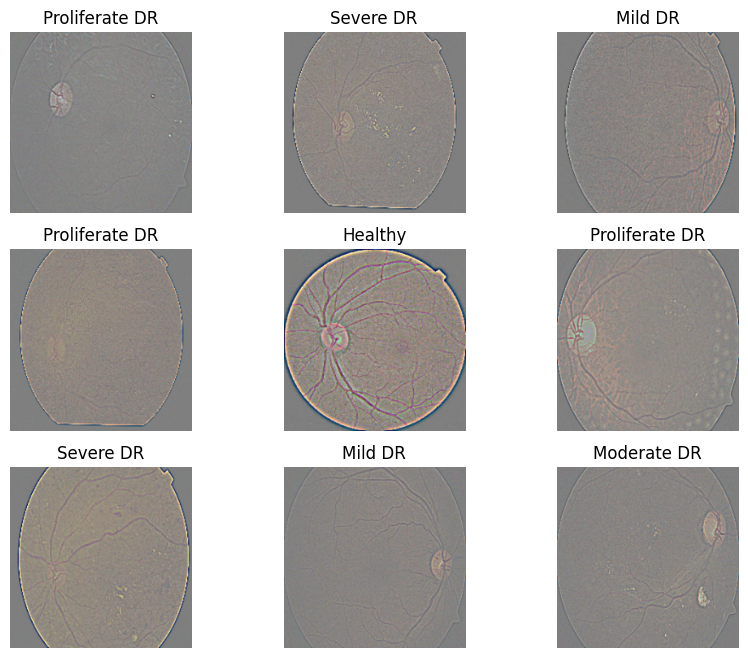

In [4]:
plt.figure(figsize=(10, 8))
for images_batch, labels_batch in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
plt.show()


## 3. Data augmentation

In [5]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.2),
    ],
    name="data_augmentation"
)


## 4. Construction du modèle EfficientNetB0

In [6]:
def build_model(num_classes):
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False  # Phase 1 : on fige le backbone

    inputs = layers.Input(shape=(224, 224, 3), name="input_image")
    x = data_augmentation(inputs)
    x = preprocess_input(x)                  # même préprocessing partout
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(
        256,
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="EfficientNetB0_transfer")
    return model

model = build_model(num_classes)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB0_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 5. Entraînement – Phase 1 (tête du réseau)

In [7]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-7
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    )
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.3004 - loss: 1.6732 - val_accuracy: 0.4740 - val_loss: 1.3632 - learning_rate: 1.0000e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.4417 - loss: 1.4412 - val_accuracy: 0.4792 - val_loss: 1.2736 - learning_rate: 1.0000e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.5046 - loss: 1.3294 - val_accuracy: 0.5417 - val_loss: 1.1824 - learning_rate: 1.0000e-04
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.5259 - loss: 1.2344 - val_accuracy: 0.5573 - val_loss: 1.1646 - learning_rate: 1.0000e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.5332 - loss: 1.1930 - val_accuracy: 0.5312 - val_loss: 1.1667 - learning_rate: 1.0000e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.5392 - loss: 1.1716 - val_accuracy: 0.5781 - val_loss: 1.1142 - learning_rate: 1.0000e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.5359 

## 6. Entraînement – Phase 2 (fine-tuning du backbone)

In [8]:
# On récupère le backbone
base_model = model.get_layer("efficientnetb0")
base_model.trainable = True

# On ne dégèle que les dernières couches pour éviter l'overfitting
for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.4380 - loss: 1.3371 - val_accuracy: 0.6406 - val_loss: 1.0025 - learning_rate: 1.0000e-05
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.4679 - loss: 1.2434 - val_accuracy: 0.6250 - val_loss: 1.0264 - learning_rate: 1.0000e-05
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.4978 - loss: 1.2156 - val_accuracy: 0.6198 - val_loss: 1.0421 - learning_rate: 1.0000e-05
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - accuracy: 0.4964 - loss: 1.2159 - val_accuracy: 0.6094 - val_loss: 1.0535 - learning_rate: 1.0000e-05
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.4991 - loss: 1.1981 - val_accuracy: 0.6094 - val_loss: 1.0555 - learning_rate: 3.0000e-06
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.5375 - loss: 1.1504 - val_accuracy: 0.6146 - val_loss: 1.0589 - learning_rate: 3.0000e-06
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.5385 

## 7. Courbes d'apprentissage

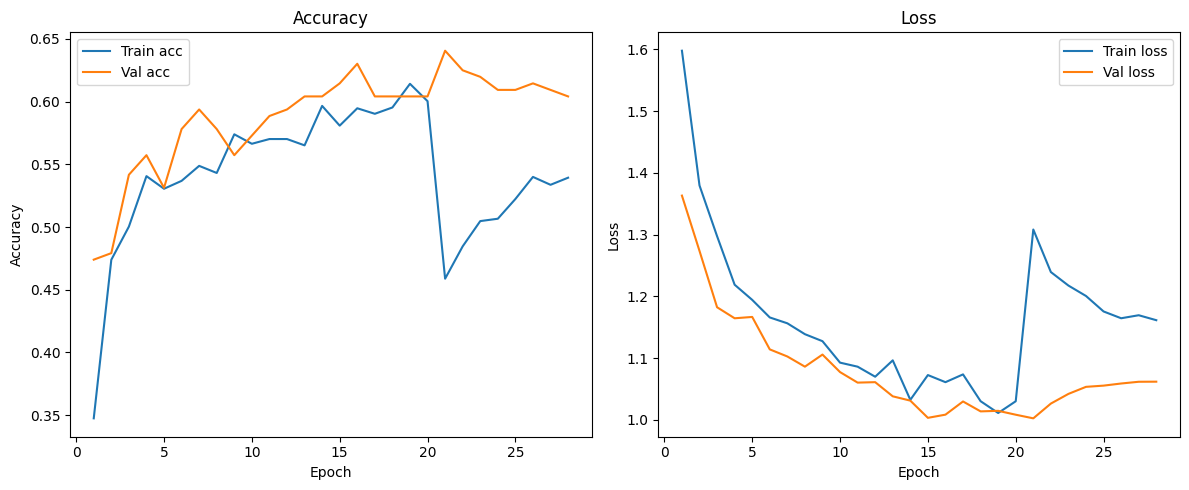

In [9]:
# Fusionner les historiques
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train acc')
plt.plot(epochs_range, val_acc, label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train loss')
plt.plot(epochs_range, val_loss, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 8. Évaluation sur le jeu de test

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy :", test_acc)
print("Test loss :", test_loss)


7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5978 - loss: 1.0407
Test accuracy : 0.5951219797134399
Test loss : 1.0504533052444458


## 9. Prédiction sur une image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Classe prédite : Healthy
Confiance : 0.360042929649353


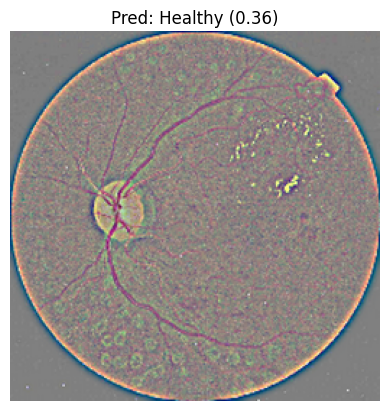

In [13]:
#  À MODIFIER avec le chemin d'une image de test
img_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning CNN DIABETIC/DATASETDIABETIC/Proliferate DR/Proliferate DR_221.png"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# même préprocessing que pendant le training
img_array = preprocess_input(img_array)

preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])
confidence = float(np.max(preds))

print("Classe prédite :", class_names[predicted_class])
print("Confiance :", confidence)

plt.imshow(image.load_img(img_path))
plt.title(f"Pred: {class_names[predicted_class]} ({confidence:.2f})")
plt.axis("off")
plt.show()


Found 1986 files belonging to 5 classes.
Using 595 files for validation.
Classes : ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']
30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step
Labels utilisés : [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Noms utilisés   : ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']


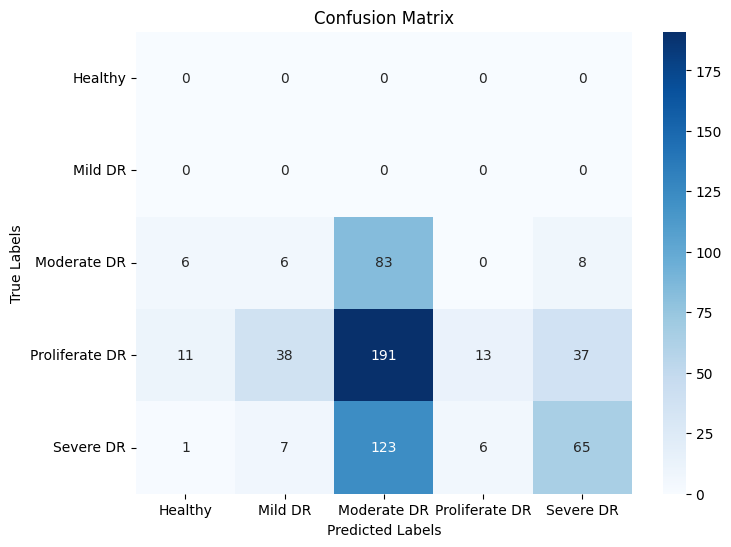

                precision    recall  f1-score   support

       Healthy       0.00      0.00      0.00         0
       Mild DR       0.00      0.00      0.00         0
   Moderate DR       0.21      0.81      0.33       103
Proliferate DR       0.68      0.04      0.08       290
     Severe DR       0.59      0.32      0.42       202

      accuracy                           0.27       595
     macro avg       0.30      0.23      0.17       595
  weighted avg       0.57      0.27      0.24       595



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Dataset de test (même chemin / paramètres que ton modèle)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Deep Learning CNN DIABETIC/DATASETDIABETIC",
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=20,
    shuffle=False
)

class_names = test_ds.class_names
print("Classes :", class_names)

# Vrais labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Prédictions du modèle
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

#  On définit les labels sur la base de y_true + y_pred
all_labels = sorted(np.unique(np.concatenate([y_true, y_pred])))

# On ne garde que ceux qui existent dans class_names (sécurité)
valid_labels = [l for l in all_labels if l < len(class_names)]
correct_names = [class_names[i] for i in valid_labels]

print("Labels utilisés :", valid_labels)
print("Noms utilisés   :", correct_names)

#  Matrice de confusion avec labels explicites
cm = confusion_matrix(y_true, y_pred, labels=valid_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=correct_names,
    yticklabels=correct_names
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report avec les mêmes labels
print(classification_report(
    y_true,
    y_pred,
    labels=valid_labels,
    target_names=correct_names
))


## 10. Sauvegarde du modèle

In [ ]:
# Sauvegarde du modèle complète (poids + architecture)
model.save("efficientnetb0_cnn_transfer.h5")
print("Modèle sauvegardé sous efficientnetb0_cnn_transfer.h5")
